In [15]:
from Generator import Generator
from test_backendclient import TestBackendClient
from typing import List
import logging
import sys

from models import ScenarioCreate

# 기존 핸들러들 제거 (중복 방지)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# 로깅 설정 추가 (콘솔 + 파일)
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),  # 노트북 출력으로 로그 표시
    ]
)

# 루트 로거 레벨 설정
logger = logging.getLogger()
logger.setLevel(logging.INFO)



generator = Generator()
backend_client = TestBackendClient()

def load_artifacts(task_id: str) -> List:
    job_id = "test+job_id"
    artifacts = backend_client.load_artifacts(task_id, job_id)
    return artifacts

def pretty_print_scenario(scenario: ScenarioCreate):
    """시나리오 객체를 받아 가독성 좋은 보고서 형태로 출력합니다."""
    
    print("="*80)
    print(f"📜 시나리오 분석 보고서: {scenario.name}")
    print("="*80)
    
    print("\n[ 보고서 개요 ]")
    print(f"  - {scenario.description}")
    
    print("\n[ 식별 정보 ]")
    print(f"  - Job ID: {scenario.job_id}")
    print(f"  - Task ID: {scenario.task_id}")
    
    print("\n[ 재구성된 공격 단계 (Timeline) ]")
    print("-" * 80)
    
    if not scenario.steps:
        print("  (분석된 단계가 없습니다.)")
    else:
        # 시간 순서대로 정렬 (이미 정렬되어 있지만 안전장치)
        sorted_steps = sorted(scenario.steps, key=lambda s: s.order_no)
        
        for step in sorted_steps:
            # datetime 객체를 보기 좋은 문자열로 포맷팅
            timestamp_str = step.timestamp.strftime('%Y-%m-%d %H:%M:%S') if step.timestamp else ""
            
            # 아티팩트 ID 리스트를 콤마로 구분된 문자열로 변환
            artifacts_str = ", ".join(step.artifact_ids)
            
            print(f"\n▶ Step {step.order_no}: [{timestamp_str}]")
            print(f"  - 내용: {step.description}")
            print(f"  - 연관 아티팩트: [{artifacts_str}]")
    
    print("\n" + "="*80)

2025-10-10 12:34:14,163 - test_backendclient - INFO - Initialized TestBackendClient


In [16]:
from dotenv import load_dotenv
from typing import Annotated, List

from typing_extensions import TypedDict

from langchain.chat_models import init_chat_model
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage

load_dotenv("../.env")

llm_sm = init_chat_model("google_genai:gemini-2.0-flash", temperature=0)
llm_lg = init_chat_model("google_genai:gemini-2.5-pro", temperature=0)

In [ ]:
import json

from langchain_core.prompts import ChatPromptTemplate

structured_llm = llm_lg.with_structured_output(ScenarioCreate)

# 상태 정의
class AgentState(TypedDict):
    artifacts: list[dict]
    analysis_result: ScenarioCreate
    requirement_context: str


def analyze_requirements(state: AgentState) -> dict:
    """
    요구사항을 분석하고 context를 생성하는 노드.
    현재는 빈 텍스트를 반환합니다.
    """
    print("--- 요구사항 분석 노드 실행 ---")
    # 나중에는 이곳에서 실제 요구사항 분석 로직이 수행됩니다.
    system_requirement = [
        "description은 중학생도 이해할 수 있도록 쉬운 단어와 명료한 문장으로 작성되어야 합니다.",
        "보고서는 일반 회사에서 관련 전문지식이 없는 사람들을 위한 것입니다.",
        "사실관계를 기반으로 분석하며, 의견인 경우에는 의견이라고 명시해 주세요.",
        "모든 아티팩트를 분석결과에 포함할 필요는 없습니다.",
        "의심되는 정황이 없다면 의심 정황이 없다고 결과를 도출해 주세요."
    ]
    context = "\n".join(system_requirement)
    return {"requirement_context": context}


def analyze_artifacts(state: AgentState):
    """아티팩트 리스트를 분석하여 구조화된 결과로 반환하는 노드"""
    
    requirement = state["requirement_context"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "당신은 주어진 아티팩트들을 분석하고 결과를 요약하는 전문 분석가입니다. 반드시 지정된 포맷으로만 결과를 출력해야 합니다."),
        ("human", "다음 요구사항을 바탕으로 분석을 진행해 주세요:\n[요구사항]: {requirement}\n\n"
"사내 주요 기밀정보(고객정보, 사내 데이터, 설계도 등)의 유출 정황을 파악하기 위해 다음 아티팩트 목록을 분석해 주세요:\n\n{artifacts_text}")
    ])
    
    # 프롬프트와 LLM 체인 연결
    analyzer_chain = prompt | structured_llm
    
    # 아티팩트 리스트를 문자열로 변환
    formatted_artifacts = []
    for artifact in state["artifacts"]:
        # data 필드의 모든 키-값 쌍을 문자열로 변환합니다.
        # json.dumps를 사용하면 중첩된 구조도 깔끔하게 표현할 수 있습니다.
        data_details = json.dumps(artifact.get('data', {}), ensure_ascii=False)
        
        # 각 아티팩트의 핵심 정보를 하나의 문자열로 결합합니다.
        formatted_string = (
            f"유형: {artifact.get('artifact_type', 'N/A')}, "
            f"요약: {artifact.get('summary', 'N/A')}, "
            f"수집 시각: {artifact.get('collected_at', 'N/A')}, "
            f"세부 데이터: {data_details}"
        )
        formatted_artifacts.append(formatted_string)
    
    # 잘 가공된 문자열 리스트를 하나로 합칩니다.
    artifacts_text = "\n- ".join(formatted_artifacts)
    
    # 체인 실행 -> 바로 AnalysisResult 객체가 반환됨
    result_object = analyzer_chain.invoke({
        "requirement": requirement,
        "artifacts_text": artifacts_text
    })
    
    return {"analysis_result": result_object}

In [18]:
# ----------------------------------------------------
#               그래프 구성 및 실행 부분
# ----------------------------------------------------
from langgraph.graph import StateGraph, END


# 1. 그래프 객체 생성
workflow = StateGraph(AgentState)

# 2. 노드 추가
# "analyzer"라는 이름으로 analyze_artifacts 함수를 노드로 등록
workflow.add_node("requirement_analyzer", analyze_requirements)
workflow.add_node("analyzer", analyze_artifacts)

# 3. 진입점 및 엣지 설정
# 그래프의 시작점을 "analyzer" 노드로 지정
workflow.set_entry_point("requirement_analyzer")
# "analyzer" 노드가 끝나면, 그래프를 종료(END)하도록 엣지를 추가
workflow.add_edge("requirement_analyzer", "analyzer")
workflow.add_edge("analyzer", END)

# 4. 그래프 컴파일
# 정의된 노드와 엣지를 바탕으로 실행 가능한 객체를 생성
app = workflow.compile()

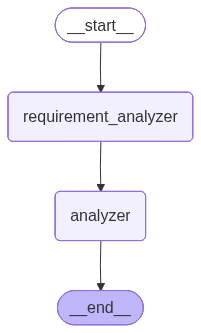

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [20]:
artifacts = load_artifacts("test")

initial_state = {"artifacts": artifacts}

final_state = app.invoke(initial_state)

print("--- 분석 결과 ---")
pretty_print_scenario(final_state['analysis_result'])

2025-10-10 12:34:14,809 - test_backendclient - INFO - [Test] load_artifacts called for task test, job test+job_id
--- 요구사항 분석 노드 실행 ---
--- 분석 결과 ---
📜 시나리오 분석 보고서: 사내 기밀 정보 유출 정황 분석

[ 보고서 개요 ]
  - 컴퓨터 사용 기록을 분석한 결과, 악성코드가 실행되고 내부 자료가 외부로 전송된 정황이 발견되었습니다. 공격자는 흔적을 지우기 위해 관련 파일을 삭제한 것으로 보입니다. (의견) 이는 의도적인 정보 유출 시도일 가능성이 높습니다.

[ 식별 정보 ]
  - Job ID: j-123
  - Task ID: t-456

[ 재구성된 공격 단계 (Timeline) ]
--------------------------------------------------------------------------------

▶ Step 1: [2025-09-23 04:55:59]
  - 내용: 사용자가 의심스러운 웹사이트에 접속하여 'malicious_file.exe' 파일을 다운로드했습니다. 이후, 바로가기(.lnk) 파일을 통해 악성 스크립트가 실행되었고, 'malicious_app.exe' 프로그램이 동작한 기록이 확인되었습니다. 이는 외부 공격을 받거나 내부자가 악성 프로그램을 직접 실행했을 가능성을 보여줍니다.
  - 연관 아티팩트: [browser_download/2025-09-23T04:55:59, browser_history/2025-09-23T04:55:59, lnk_file/2025-09-23T04:56:05, prefetch_file/2025-09-23T04:56:12]

▶ Step 2: [2025-09-23 04:56:09]
  - 내용: 메신저(텔레그램)를 통해 'confidential_data.zip' 파일이 외부로 전송되었습니다. 또한, USB 저장장치와 휴대폰이 PC에 연결된 기록이 있어, 이를 통